In [1]:
from google.colab import drive
drive.mount('/content/drive')
import requests
from bs4 import BeautifulSoup
import json
import numpy as np
import pandas as pd
import math
import time
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans


Mounted at /content/drive


In [ ]:
# 숨찌마라
base_url='https://logs.fau.dev/api/logs?scope=arkesia&order=recent%20clear'

params = {
"raids": {},
"guardians": [],
"trials": [],
"classes": ["Machinist"],
"search": ""
}

r = requests.get(base_url, json=params)
json_data = json.loads(BeautifulSoup(r.text, 'html.parser').text)

donothide = []
count=0

while json_data['more']:
  time.sleep(0.2)
  encounter_id = [encounter['id'] for encounter in json_data['encounters']]
  encounter_date = [encounter['date'] for encounter in json_data['encounters']]
  encounter_place = [encounter['place'] for encounter in json_data['encounters']]
  donothide.extend(encounter_id)
  add_url = f'https://logs.fau.dev/api/logs?scope=arkesia&past_id={encounter_id[-1]}&past_place={encounter_place[-1]}&past_field={encounter_date[-1]}&order=recent%20clear'
  r = requests.post(add_url, json=params)
  json_data = json.loads(BeautifulSoup(r.text, 'html.parser').text)
  count+=1
  if count%200==0:
    print(f"숨찌마라! {count}명의 스카우터!!!")
  if count>10000:
    break


#저장
with open('/content/drive/MyDrive/donothide.csv','w',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(donothide)

In [ ]:
#숨찌마라 34985명의 스카우터!!!!!
donothide=list(pd.read_csv('/content/drive/MyDrive/donothide.csv'))

In [ ]:
donothide_1000=donothide[:1000]

In [ ]:
#과연 스까우터 시너지의 유지 현황은 어떨까?

synergy_hide_df=pd.DataFrame()
count=0

for k in donothide_1000:
  try:
    encounter_url = f'https://logs.fau.dev/api/log/{k}'
    encounter_json = json.loads(BeautifulSoup(requests.get(encounter_url).text, 'html.parser').text)
    #시너지 있는 df 만들기
    for i in encounter_json['data']['players'].keys():
      temp_df = pd.DataFrame.from_dict(encounter_json['data']['players'][i]['synergy'], orient='index')
      synergy_hide_df=pd.concat([synergy_hide_df,temp_df],axis=0)
  except:
    pass

  count+=1
  if count%1000==0:
    print(f"{count}명 집계 완료")

#percent 숫자형으로 바꾸기
synergy_hide_df['percent']=synergy_hide_df['percent'].astype(float)

#index 초기화해서 name column 만들기
synergy_hide_df.reset_index(inplace=True)
synergy_hide_df.rename(columns={'index': 'name'}, inplace=True)

synergy_hide_df
#synergy_hide= pd.DataFrame(synergy_hide_df.groupby('name')['percent'].mean())

1000명 집계 완료


,name,damage,percent,buffs
0,102_230102,156802678,86.3,{'161210': 156802678}
1,505_240505,135114179,74.4,{'357501': 135114179}
2,512_380503,144677181,79.6,"{'381820': 82286921, '382030': 62390260}"
3,602_210230,180050292,99.1,{'314260': 180050292}
4,602_310501,96369094,53.0,{'310501': 96369094}
...,...,...,...,...
41521,105_210230,2951112088,84.8,{'360506': 2951112088}
41522,105_368000,985615946,28.3,{'500153': 985615946}
41523,112_230112,3208123345,92.2,{'452230': 3208123345}
41524,505_240505,2526635091,72.6,{'357501': 2526635091}


In [ ]:
#숨찌마라의 시너지 유지율!!
donothide=synergy_hide_df[synergy_hide_df['name'].str.contains('^505',regex=True)]['percent']
donothide_df=pd.DataFrame({
    "synergy":donothide
})
sns.histplot(donothide, bins=40, kde=True)

,name,damage,percent,buffs
0,102_230102,156802678,86.3,{'161210': 156802678}
1,505_240505,135114179,74.4,{'357501': 135114179}
2,512_380503,144677181,79.6,"{'381820': 82286921, '382030': 62390260}"
3,602_210230,180050292,99.1,{'314260': 180050292}
4,602_310501,96369094,53.0,{'310501': 96369094}
...,...,...,...,...
41521,105_210230,2951112088,84.8,{'360506': 2951112088}
41522,105_368000,985615946,28.3,{'500153': 985615946}
41523,112_230112,3208123345,92.2,{'452230': 3208123345}
41524,505_240505,2526635091,72.6,{'357501': 2526635091}


In [ ]:
#숨찌마라 직각 분류
kmeans = KMeans(n_clusters=2, random_state=42)
donothide_df['cluster'] = kmeans.fit_predict(np.array(donothide).reshape(-1,1))

,synergy,cluster
1,74.4,0
7,68.8,1
13,76.2,0
19,94.3,0
34,60.7,1
...,...,...
41502,89.3,0
41507,86.4,0
41513,94.2,0
41518,84.2,0


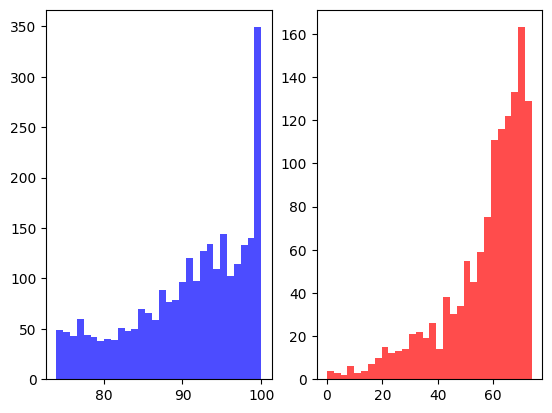

In [ ]:
a=donothide_df[donothide_df['cluster']==0]['synergy']
b=donothide_df[donothide_df['cluster']==1]['synergy']

plt.subplot(1, 2, 1)
plt.hist(a, bins=30, alpha=0.7, color='blue')

plt.subplot(1, 2, 2)
plt.hist(b, bins=30, alpha=0.7, color='red')

plt.show()

In [ ]:
list(donothide)

[74.4,
 68.8,
 76.2,
 94.3,
 60.7,
 72.0,
 87.1,
 65.7,
 73.2,
 77.7,
 84.0,
 93.8,
 9.1,
 1.8,
 8.1,
 3.1,
 96.6,
 98.4,
 98.5,
 96.3,
 62.8,
 70.9,
 72.9,
 92.5,
 84.7,
 88.6,
 77.2,
 64.9,
 52.2,
 38.2,
 78.1,
 59.6,
 28.8,
 25.4,
 29.7,
 23.9,
 53.5,
 58.9,
 84.1,
 55.8,
 66.4,
 91.9,
 72.9,
 57.9,
 67.2,
 69.6,
 80.3,
 93.3,
 98.3,
 97.4,
 96.0,
 100.0,
 48.1,
 89.5,
 61.0,
 59.7,
 99.1,
 96.1,
 90.1,
 100.0,
 71.9,
 92.6,
 60.5,
 66.7,
 42.6,
 45.4,
 91.6,
 28.5,
 83.6,
 75.1,
 79.0,
 94.3,
 50.6,
 89.8,
 58.3,
 57.3,
 99.9,
 98.3,
 99.9,
 99.9,
 99.8,
 96.9,
 94.3,
 99.6,
 88.9,
 88.3,
 79.9,
 84.8,
 61.3,
 75.4,
 93.7,
 71.9,
 97.4,
 98.2,
 98.6,
 98.6,
 70.1,
 69.3,
 93.9,
 71.8,
 73.8,
 91.6,
 43.9,
 69.6,
 86.1,
 72.5,
 89.2,
 78.6,
 78.4,
 94.4,
 45.3,
 74.2,
 93.1,
 78.5,
 100.0,
 91.0,
 99.6,
 99.8,
 99.9,
 95.8,
 86.0,
 99.1,
 98.2,
 93.7,
 74.4,
 98.8,
 90.0,
 100.0,
 89.3,
 50.6,
 62.0,
 58.1,
 64.4,
 96.7,
 95.0,
 98.3,
 92.2,
 43.5,
 48.1,
 53.8,
 97.9,
 100.0,
 97.7

In [ ]:
# 카멘 하드 2,3,4 관문 데이터
base_url='https://logs.fau.dev/api/logs?scope=arkesia&order=recent%20clear'

params = {
"raids": {
"Thaemine": {
"gates": [2,3,4],
"difficulties": ['Hard']}
},
"guardians": [],
"trials": [],
"classes": [],
"search": ""
}

r = requests.post(base_url, json=params)
json_data = json.loads(BeautifulSoup(r.text, 'html.parser').text)

Thaemine_Hard_id = []
count=0

while json_data['more']:
  time.sleep(0.2)
  encounter_id = [encounter['id'] for encounter in json_data['encounters']]
  encounter_date = [encounter['date'] for encounter in json_data['encounters']]
  encounter_place = [encounter['place'] for encounter in json_data['encounters']]
  Thaemine_Hard_id.extend(encounter_id)
  add_url = f'https://logs.fau.dev/api/logs?scope=arkesia&past_id={encounter_id[-1]}&past_place={encounter_place[-1]}&past_field={encounter_date[-1]}&order=recent%20clear'
  r = requests.post(add_url, json=params)
  json_data = json.loads(BeautifulSoup(r.text, 'html.parser').text)
  count+=1

#저장
with open('/content/drive/MyDrive/Thaemine_Hard_id.csv','w',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(Thaemine_Hard_id)

In [ ]:
Thamine_Hard_id=list(pd.read_csv('/content/drive/MyDrive/Thaemine_Hard_id.csv'))

In [ ]:
Thamine_Hard_id[0]

'1300931'

In [ ]:
encounter_url = 'https://logs.fau.dev/api/log/1383895'
encounter_json = json.loads(BeautifulSoup(requests.get(encounter_url).text, 'html.parser').text)

In [ ]:
encounter_json['difficulty']

{'uploader': None,
 'id': 1383895,
 'difficulty': 'Hard',
 'boss': 'Valinak, Herald of the End',
 'date': 1716905095004,
 'duration': 709955,
 'localPlayer': 'Souleater #1',
 'anonymized': True,
 'actual': True,
 'place': 0,
 'visibility': {'names': 3},
 'players': {'Deathblade #2': {'name': 'Deathblade #2',
   'class': 'Deathblade',
   'gearScore': 1631.6600341796875,
   'damage': 12535431145,
   'percent': '17.2',
   'dps': 17680438,
   'dead': False,
   'deadFor': 1716905803847,
   'highlight': None},
  'Gunslinger #6': {'name': 'Gunslinger #6',
   'class': 'Gunslinger',
   'gearScore': 1630,
   'damage': 9549450296,
   'percent': '13.1',
   'dps': 13468900,
   'dead': False,
   'deadFor': 1716905803847,
   'highlight': None},
  'Machinist #5': {'name': 'Machinist #5',
   'class': 'Machinist',
   'gearScore': 1631.6600341796875,
   'damage': 11224882362,
   'percent': '15.4',
   'dps': 15831992,
   'dead': False,
   'deadFor': 1716905803847,
   'highlight': None},
  'Paladin #7': {'

In [ ]:
# 직업 리스트(# 없는 정제버전)
job = [cl[:cl.index('#')].strip() for cl in list(encounter_json['players'].keys())]

#직업별 메인 스킬 코드>>차후 직각 분류에 사용
main_skill=[max(encounter_json['data']['players'][i]['skillDamage'],key=lambda k:encounter_json['data']['players'][i]['skillDamage'][k]['damage'])for i in encounter_json['data']['players'].keys() ]

#8인 dps
dps=[encounter_json['players'][i]['dps'] for i in encounter_json['players'].keys()]

#누군가 죽었는지 알아보기 , json 자리에는 list(encounter_json['players'].keys()) 입력
def die (json):
  for i in json:
    if encounter_json['players'][i]['dead']:
      return 1
      break
  return 0

die_TF=die(list(encounter_json['players'].keys()))

#시너지 유지율 확인 >>>>>> 나중에 보강
encounter_json['data']['players']['Artist #8']['synergy']

synergy=0

#템렙(버림값)
gearScore=[math.floor(encounter_json['players'][i]['gearScore'])for i in encounter_json['data']['players'].keys() ]

ValueError: substring not found

In [ ]:
synergy_df=pd.DataFrame()

#시너지 있는 df 만들기
for i in encounter_json['data']['players'].keys():
  temp_df = pd.DataFrame.from_dict(encounter_json['data']['players'][i]['synergy'], orient='index')
  synergy_df=pd.concat([synergy_df,temp_df],axis=0)

#percent 숫자형으로 바꾸기
synergy_df['percent']=synergy_df['percent'].astype(float)

#index 초기화해서 name column 만들기
synergy_df.reset_index(inplace=True)
synergy_df.rename(columns={'index': 'name'}, inplace=True)

synergy= pd.DataFrame(synergy_df.groupby('name')['percent'].mean())

,name,damage,percent,buffs
0,105_101105,11415953754,91.1,"{'361708': 5703747934, '362006': 5712205820}"
1,105_210230,12021286316,95.9,{'360804': 12021286316}
2,105_368000,4913651721,39.2,{'500153': 4913651721}
3,312_390801,10776384258,86.0,"{'390803': 7598030861, '392900': 3178353397}"
4,312_Lightning Whisper,6067220860,48.4,{'390802': 6067220860}
5,402_310403,11634016261,92.8,{'250411': 11634016261}
6,402_Maelstrom,4943151688,39.4,{'251640': 4943151688}
7,505_240505,10995149988,87.7,{'350502': 10995149988}
8,105_101105,8045137155,84.2,"{'361708': 3924712310, '362006': 4120424845}"
9,105_210230,7640578855,80.0,{'360804': 7640578855}


88.4

In [ ]:
#직업별 딜 지분률 알아보기
main_skill=[max(encounter_json['data']['players'][i]['skillDamage'],key=lambda k:encounter_json['data']['players'][i]['skillDamage'][k]['damage'])for i in encounter_json['data']['players'].keys() ]

['607016240',
 '25038',
 '34590',
 '35800',
 '607016240',
 '37350',
 '22340',
 '22340']

In [ ]:
#각 직업 dps
dps=[encounter_json['players'][i]['dps'] for i in encounter_json['players'].keys() ]

In [ ]:
#누군가 죽었는지 알아보기 , json 자리에는 list(encounter_json['players'].keys()) 입력
def die (json):
  for i in json:
    if encounter_json['players'][i]['dead']:
      return 1
      break
  return 0

die_TF=die(list(encounter_json['players'].keys()))

0

In [ ]:
#템렙(버림값)
gearScore=[math.floor(encounter_json['players'][i]['gearScore'])for i in encounter_json['data']['players'].keys() ]

[1631, 1640, 1633, 1631, 1631, 1640, 1635, 1635]

In [ ]:
#방어구 5부위 기준 뎀증 1.3% , 무기 1강 당 1.6% 의 딜상승
#6부위 강화=5렙 증가 당 1.013*1.0166=1.0298 씩 강해진다
#즉 1레벨당 1.0298의 5제곱근 = 1.00584 씩 강해진다

# 로아 영문 각인 이름
'''
워로드 - Gunlancer
ㄴ 고독한 기사 - Lone Knight
ㄴ 전투 태세 - Combat Readiness

버서커 - Berserker
ㄴ 광전사의 비기 - Berserker's Technique
ㄴ 광기 - Mayhem

홀리나이트 - Paladin
ㄴ 심판자 - Judgment
ㄴ 축복의 오라 - Blessed Aura

인파이터 - Scrapper
ㄴ 극의 : 체술 - Ultimate Skill : Taijutsu
ㄴ 충격 단련 - Shock Training

기공사 - Soulfist
ㄴ 세맥타통 - Energy Overflow
ㄴ 역천지체 - Robust Spirit

배틀마스터 - Wardancer
ㄴ 초심 - First Intention
ㄴ 오의강화 - Esoteric Skill Enhnacement

스트라이커 - Striker
ㄴ 일격필살 - Deathblow
ㄴ 오의난무 - Esoteric Flurry

데빌헌터 - Deadeye
ㄴ 강화 무기 - Enhanced Weapon
ㄴ 핸드거너 - Pistoleer

블래스터 - Artillerist
ㄴ 화력 강화 - Firepower Enhancement
ㄴ 포격 강화 - Barrage Enhancement

호크아이 - Sharpshooter
ㄴ 두 번째 동료 - Loyal Companion
ㄴ 죽음의 습격 - Death Strike

건슬링어 - Gunslinger
ㄴ 사냥의 시간 - Time to Hunt
ㄴ 피스메이커 - Peacemaker

바드 - Bard
ㄴ 진실된 용맹 - True Courage
ㄴ 절실한 구원 - Desperate Salvation

소서리스 - Sorceress
ㄴ 점화 - Igniter
ㄴ 환류 - Reflux

블레이드 - Deathblade
ㄴ 잔재된 기운 - Remaining Energy
ㄴ 버스트 - Surge

데모닉 - Shadowhunter
ㄴ 멈출 수 없는 충동 - Demonic Impulse
ㄴ 완벽한 억제 - Perfect Suppresion
'''

In [ ]:
Main_df=pd.DataFrame()
synergy_df=pd.DataFrame()
count=0

for k in Thamine_Hard_id:
  #카멘 데이터
  encounter_url = f'https://logs.fau.dev/api/log/{k}'
  encounter_json = json.loads(BeautifulSoup(requests.get(encounter_url).text, 'html.parser').text)

  #시너지 있는 df 만들기
  for i in encounter_json['data']['players'].keys():
    temp_df = pd.DataFrame.from_dict(encounter_json['data']['players'][i]['synergy'], orient='index')
    synergy_df=pd.concat([synergy_df,temp_df],axis=0)

  # 직업 리스트(# 없는 정제버전)
  job=[]
  for cl in list(encounter_json['players'].keys()):
    try:
      job.append(cl[:cl.index('#')].strip())
    except:
      job.append(cl.strip())

  #직업별 메인 스킬 코드>>차후 직각 분류에 사용
  main_skill=[max(encounter_json['data']['players'][i]['skillDamage'],key=lambda k:encounter_json['data']['players'][i]['skillDamage'][k]['damage'])for i in encounter_json['data']['players'].keys() ]


  #8인 dps
  dps=[encounter_json['players'][i]['dps'] for i in encounter_json['players'].keys()]

  #누군가 죽었는지 알아보기 , json 자리에는 list(encounter_json['players'].keys()) 입력
  def die (json):
    for i in json:
      if encounter_json['players'][i]['dead']:
        return 1
        break
    return 0

  die_TF=die(list(encounter_json['players'].keys()))

  #템렙(버림값)
  gearScore=[math.floor(encounter_json['players'][i]['gearScore'])for i in encounter_json['data']['players'].keys() ]

  #관문명
  boss=encounter_json['boss']

  #난이도
  difficulty=encounter_json['difficulty']

  #df 만들기
  df = pd.DataFrame({
      'dps': dps,
      'main_skill': main_skill,
      'gearScore': gearScore,
      'die_TF': die_TF,
      'boss': boss,
      'difficulty': difficulty
  })
  df.index=job

  df['1630_dps']=[int(df['dps'].iloc[i]/(1.00584**(df['gearScore'].iloc[i]-1630))) for i in range(df.shape[0])]

  Main_df=pd.concat([Main_df,df],axis=0)

  count+=1

#시너지 df 계산 위해percent 숫자형으로 바꾸기
synergy_df['percent']=synergy_df['percent'].astype(float)

#index 초기화해서 name column 만들기
synergy_df.reset_index(inplace=True)
synergy_df.rename(columns={'index': 'name'}, inplace=True)

synergy= pd.DataFrame(synergy_df.groupby('name')['percent'].mean())

Main_df.reset_index(inplace=True)
Main_df.rename(columns={'index': 'class'}, inplace=True)

synergy.reset_index(inplace=True)
synergy.rename(columns={'index': 'skill_name'}, inplace=True)

#저장
Main_df.to_feather('/content/drive/MyDrive/LostArk_df.feather')
synergy.to_feather('/content/drive/MyDrive/donothide.feather')



,name,percent
0,102_230102,79.413410
1,103_300103,80.500463
2,104_300104,77.832679
3,104_310104,58.003207
4,104_Lance of Judgment,5.641704
5,105_101105,81.652765
6,105_210230,83.127711
7,105_360102,28.666667
8,105_368000,35.738597
9,112_230112,80.107354


In [6]:
# 데이터 불러오기
Main_df=pd.read_feather('/content/drive/MyDrive/LostArk_df.feather')
synergy=pd.read_feather('/content/drive/MyDrive/donothide.feather')

,name,percent
0,102_230102,79.413410
1,103_300103,80.500463
2,104_300104,77.832679
3,104_310104,58.003207
4,104_Lance of Judgment,5.641704
5,105_101105,81.652765
6,105_210230,83.127711
7,105_360102,28.666667
8,105_368000,35.738597
9,112_230112,80.107354


In [16]:
#진정한 숙제팟은..역시나 적었다...
homework=Main_df[Main_df['die_TF']==0]

,class,dps,main_skill,gearScore,die_TF,boss,difficulty,1630_dps
0,Bard,608189,607016240,1640,1,"Thaemine, Conqueror of Stars",Hard,573785
1,Bard,607062,607016240,1635,1,"Thaemine, Conqueror of Stars",Hard,589642
2,Deathblade,34577983,25038,1645,1,"Thaemine, Conqueror of Stars",Hard,31685905
3,Diergonn,28090857,34120,1646,1,"Thaemine, Conqueror of Stars",Hard,25591901
4,Gunlancer,16708362,17200,1631,1,"Thaemine, Conqueror of Stars",Hard,16611351
...,...,...,...,...,...,...,...,...
22749,Jennysouls,18227019,24210,1630,0,"Valinak, Herald of the End",Hard,18227019
22750,Llirrss,255015,21290,1635,0,"Valinak, Herald of the End",Hard,247697
22751,Memeslash,17980163,22340,1633,0,"Valinak, Herald of the End",Hard,17668794
22752,Shimô,15488072,19050,1633,0,"Valinak, Herald of the End",Hard,15219859


In [19]:
#main_skill 로 묶었을 때 표본이 몇개나 나올까용
job_count=[(homework[homework['main_skill']==i]).shape[0] for i in homework['main_skill'].unique()]
job_count_13=[map(lamda: if i job_count[i]>=13 )]

SyntaxError: invalid syntax (<ipython-input-19-49585931bd03>, line 1)

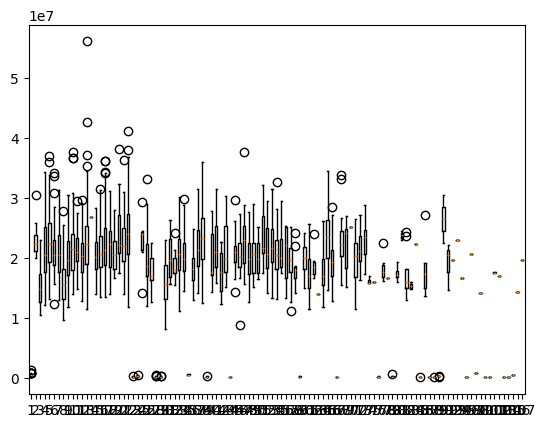

In [20]:
plt.boxplot([homework[homework['main_skill']==i]['1630_dps'] for i in homework['main_skill'].unique()])
plt.show()

In [ ]:
synergy.sort_values(by='percent')

,name,percent
4,104_Lance of Judgment,5.641704
7,105_360102,28.666667
39,603_320405,28.807946
8,105_368000,35.738597
15,204_Serenade of Courage,35.971954
36,602_310501,40.108936
26,402_Maelstrom,46.274012
18,302_Wind's Whisper,51.591233
3,104_310104,58.003207
23,312_Lightning Whisper,70.965074


In [ ]:
#직업 코드
'''
const r = {
    Unknown: 0,
    "Warrior (Male)": 101,
    Berserker: 102,
    Destroyer: 103,
    Gunlancer: 104,
    Paladin: 105,
    "Female Warrior": 111,
    Slayer: 112,
    Mage: 201,
    Arcanist: 202,
    Summoner: 203,
    Bard: 204,
    Sorceress: 205,
    "Martial Artist (Female)": 301,
    Wardancer: 302,
    Scrapper: 303,
    Soulfist: 304,
    Glaivier: 305,
    "Martial Artist (Male)": 311,
    Striker: 312,
    Breaker: 313,
    Assassin: 401,
    Deathblade: 402,
    Shadowhunter: 403,
    Reaper: 404,
    Souleater: 405,
    "Gunner (Male)": 501,
    Sharpshooter: 502,
    Deadeye: 503,
    Artillerist: 504,
    Machinist: 505,
    "Gunner (Female)": 511,
    Gunslinger: 512,
    Specialist: 601,
    Artist: 602,
    Aeromancer: 603,
    Alchemist: 604
}
  , s = {
    Berserker: 102,
    Destroyer: 103,
    Gunlancer: 104,
    Paladin: 105,
    Slayer: 112,
    Arcanist: 202,
    Summoner: 203,
    Bard: 204,
    Sorceress: 205,
    Wardancer: 302,
    Scrapper: 303,
    Soulfist: 304,
    Glaivier: 305,
    Striker: 312,
    Breaker: 313,
    Deathblade: 402,
    Shadowhunter: 403,
    Reaper: 404,
    Souleater: 405,
    Sharpshooter: 502,
    Deadeye: 503,
    Artillerist: 504,
    Machinist: 505,
    Gunslinger: 512,
    Artist: 602,
    Aeromancer: 603
};
'''

(6, 6)

In [ ]:
encounter_dataset={encounter_id: {} for encounter_id in encounter_id_total}
for encounter_id in tqdm(encounter_id_total):
encounter_url = 'https://logs.fau.dev/api/log/{0}'.format(encounter_id)
encounter_json = json.loads(BeautifulSoup(requests.get(encounter_url).text, 'html.parser').text)
encounter_dataset[encounter_id]['title'] = encounter_json['boss']
encounter_dataset[encounter_id]['outdated'] = encounter_json['date']/1000 < 1704726000 # unixtimestamp, 북미패치 기준 필터링
encounter_dataset[encounter_id]['date'] = encounter_json['date']/1000 # 밀리세컨드 단위환산
encounter_dataset[encounter_id]['uploader'] = encounter_json['localPlayer']
encounter_dataset[encounter_id]['cleared'] = encounter_json['cleared']
encounter_dataset[encounter_id]['duration'] = encounter_json['duration']/(60*1000) # 분 단위로 환산
encounter_dataset[encounter_id]['players'] = encounter_json['players']
encounter_dataset[encounter_id]['data'] = encounter_json['data']
